## CSCI 470 Activities and Case Studies

1. For all activities, you are allowed to collaborate with a partner.
1. For case studies, you should work individually and are **not** allowed to collaborate.

By filling out this notebook and submitting it, you acknowledge that you are aware of the above policies and are agreeing to comply with them.

Some considerations with regard to how these notebooks will be graded:

1. Cells in which "# YOUR CODE HERE" is found are the cells where your graded code should be written.
2. In order to test out or debug your code you may also create notebook cells or edit existing notebook cells other than "# YOUR CODE HERE". We actually highly recommend you do so to gain a better understanding of what is happening. However, during grading, **these changes are ignored**.
2. You must ensure that all your code for the particular task is available in the cells that say "# YOUR CODE HERE"
3. Every cell that says "# YOUR CODE HERE" is followed by a "raise NotImplementedError". You need to remove that line. During grading, if an error occurs then you will not receive points for your work in that section.
4. If your code passes the "assert" statements, then no output will result. If your code fails the "assert" statements, you will get an "AssertionError". Getting an assertion error means you will not receive points for that particular task.
5. If you edit the "assert" statements to make your code pass, they will still fail when they are graded since the "assert" statements will revert to the original. Make sure you don't edit the assert statements.
6. We may sometimes have "hidden" tests for grading. This means that passing the visible "assert" statements is not sufficient. The "assert" statements are there as a guide but you need to make sure you understand what you're required to do and ensure that you are doing it correctly. Passing the visible tests is necessary but not sufficient to get the grade for that cell.
7. When you are asked to define a function, make sure you **don't** use any variables outside of the parameters passed to the function. You can think of the parameters being passed to the function as a hint. Make sure you're using all of those variables.
8. Finally, **make sure you run "Kernel > Restart and Run All"** and pass all the asserts before submitting. If you don't restart the kernel, there may be some code that you ran and deleted that is still being used and that was why your asserts were passing.

# Transfer Learning

We've already looked at one example of transfer learning. For NLP topic classification, we used various feature representations including using GloVe representations as the chosen word embedding. That was one example of transfer learning where the approach we used was a feature representation transfer.

In this exercise we will apply transfer learning to computer vision where we will incorporate both parameter transfer as well as feature representation transfer. You can take a look at the available pre-trained models in keras on the [applications page](https://keras.io/applications) in the documentation. In modern ML practice, we often use transfer learning to gain the benefit of state of the art models, rather than build a model from scratch.

For thie exercise, we will use the [CIFAR10 dataset](https://keras.io/datasets/#cifar10-small-image-classification).

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model

## Load, examine, and prepare the data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes = 10

170498071/170498071 [==============================] - 2s 0us/step


In [3]:
# This code simply lets us know if the TensorFlow has access
# to a GPU, or just a CPU

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14644370800337024901
 xla_global_id: -1]

In [4]:
# Let's see how many training samples we have, and the size of the images

x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [5]:
# CIFAR-10 consists of 10 object classes. Let's confirm this.

np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [6]:
# See how many test samples we have, and confirm that array sizes meet our expectations

x_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 1))

In [7]:
# We need to convert the integer-based class labels to categorical, one-hot
# encoding vectors. Note that this is analogous to our use of get_dummies()
# in pandas, which serves the same purpose except for DataFrames rather than
# numpy arrays.

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

y_train.shape, y_test.shape, y_train.min(), y_train.max()

((50000, 10), (10000, 10), 0.0, 1.0)

## Extract parameters from a pre-trained model

We'll use a VGG-16 model which has been trained on the [ImageNet ILSVRC](https://www.image-net.org/challenges/LSVRC/) image corpus of 1000 image categories. VGG-16 is a 16-layered CNN model. We'll keep the early convolutional layers and use them as a front-end for our new model, leveraging those convolutional layers for feature extraction. We'll discard the subsequent fully-connected layers (the "top") of the VGG-16 model, and instead, build a new "top" and train it for classification of CIFAR-10 images.

Note that this process is taking the feature extraction knowledge learned from the ImageNet data and "transferring" it to our new model.

You'll need to reference the [VGG16 Keras documentation](https://keras.io/api/applications/vgg/#vgg16-function) to accomplish this.

In [9]:
# Load a VGG16 model with ImageNet weights, without the fully-connected ("top") layers.
#
# Note that convolutional layers are independent of actual height and width image
# dimesions, so you have to use "input_shape" to inform the VGG16 object/model what
# the those dimensions will be.
#
# Save your model as "vgg_model".

# YOUR CODE HERE
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))

58889256/58889256 [==============================] - 0s 0us/step


In [10]:
assert vgg_model

In [11]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [12]:
# Let's look at an image sample, and then you'll confirm that you
# can use the pre-trained model for feature extraction.

example = x_train[4]
example.shape

(32, 32, 3)

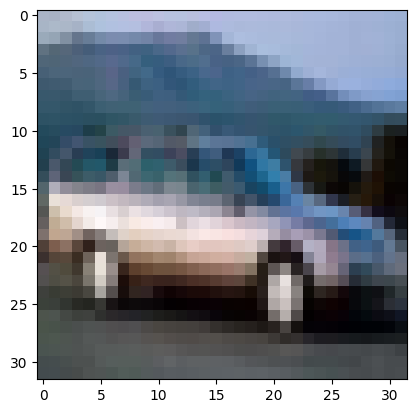

In [13]:
plt.imshow(example)
plt.show()

In [14]:
# Use vgg_model to extract the features for the example image.
# Save the output as "example_vgg".

# YOUR CODE HERE
example_vgg = vgg_model.predict(np.expand_dims(example, axis=0))

1/1 [==============================] - 0s 484ms/step


In [15]:
assert np.squeeze(example_vgg).shape == (512,)

##  Build and train a CIFAR-10 classifier model

Now let's create our own fully-connected layers and append those to the top of the `vgg_model`. We can then train our model on the CIFAR10 dataset and predict its classes. In the following code, you'll want to use Keras' [functional API](https://www.tensorflow.org/guide/keras/functional) that we've used before.

In [16]:
# Use the Keras function API to create a new set of layers that
# will take input from the output of the VGG convolutional layers.
#
# - Flatten the output of the VGG convolutional layers
# - Add 3 Dense layers with 256 units each and an appropriate activation function.
# - Add a final output layer of proper size and activation function.
#
# Save the output of the final layer as "predictions".

# Below, "x" is the output of the VGG16 layers. It will serve as the
# input to the new layers you'll create below.
x = vgg_model.output

# YOUR CODE HERE
x = Flatten(data_format=None)(x)
x = Dense(256, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(10, activation="softmax")(x)

# Now we can create a single Model that takes data from the input layer
# of the VGG convolutional layers to the output of your fully-connected layers.
vgg_complete = Model(vgg_model.input, predictions)

In [17]:
assert len(vgg_complete.layers) - len(vgg_model.layers) == 5
assert vgg_complete.layers[-2].units == 256
assert vgg_complete.layers[-3].units == 256
assert vgg_complete.layers[-4].units == 256

In [18]:
vgg_complete.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

### Train

Train your model using as many epochs as you'd like, observing it's convergence behavior.  
__But you must set `epochs=1` and re-run your notebook before turning it in.__

In [19]:
# We want to train the parameters of your new fully-connected layers,
# but not those of the convolutional layers. This is because we want to
# preserve the feature extraction capabilities of those layers as
# learned from the much larger ImageNet ILSVRC data set. "Freezing"
# the convolutional parameters will also allow our model to train more quickly.
#
# Briefly run this and the code cell below both with and without with "trainable" setting
# set to False, while observing the estimated epoch training duration ("ETA").
# Aterwards, but sure to set it back to False, and restart/rerun your notebook.
for layer in vgg_model.layers:
    layer.trainable = False

In [20]:
# This cell will take a while. Double check your work before continuing.
#
# If you set n_epochs greater than 1, to better observe convergence,
# reset it to 1 before turning in our notebook.

n_epochs = 1
vgg_complete.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])
vgg_complete.fit(x_train, y_train, epochs=n_epochs, batch_size=128)

391/391 [==============================] - 615s 2s/step - loss: 1.6503 - accuracy: 0.4966


In [21]:
# Using your model, get the accuracy score for the test set
# and save it as "acc".

# YOUR CODE HERE
loss,acc = vgg_complete.evaluate(x_test, y_test, batch_size=128)

79/79 [==============================] - 126s 2s/step - loss: 1.2783 - accuracy: 0.5607


In [22]:
print(f"Random chance accuracy on this task is approximately 0.1.\nYour model's accuracy is {acc:.3f}.")

Random chance accuracy on this task is approximately 0.1.
Your model's accuracy is 0.561.


In [23]:
assert acc > 0.3

In [24]:
assert n_epochs==1

## Additional Exercises [optional]

For further edification, consider comparing results from up to four models/situations. The ones using VGG16 will take longer to compute, but still only 10-15 minutes each if you train only for ~5 epochs. Consider training them for 10 epochs each, for clear differentiation of results.

Be sure to look at the final accuracy score of the __test set__, not just those of the training set.

1. Use the VGG-16 convolutional layers, but train all model parameters __from scratch__. To do so, simply set `weights=None` when you create `vgg_model` using `VGG16`.
2. [You did this one already] Use pre-trained VGG-16 convolutional layers, and keep those layers "frozen" during training on CIFAR-10 data.
3. Use pre-trained VGG-16 convolutional layers but in contrast to #2 above, do not freeze those layers during training on CIFAR-10 data (set `layer.trainable=True` a few cells above). This is called __fine-tuning__.
4. VGG-16 is a large model. How well does a __smaller CNN model__ do, when trained from scratch? We did that for the MNIST model in the CNN Activity. Copy that model here, adjust the input shape to (32, 32, 3) rather than (28, 28, 1), then train and evalutate that model.

__Which of the above approaches gives the best test set performance (after sufficient training epochs)?__


__Be sure to restore all original settings before your final notebook run and submittal__:
- `weights = 'imagenet'`
- `layer.trainable = False`
- `n_epochs = 1`

## Feedback

In [26]:
def feedback():
    """Provide feedback on the contents of this exercise

    Returns:
        string
    """
    # YOUR CODE HERE
    return "No comment"

In [27]:
feedback()

'No comment'